In [4]:
import pickle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
%matplotlib inline

In [5]:
running_in_drive = False

images_path = '../presentation/Azin_images'
models_path = '../code/Azin_models'
data_path = '../data'


if running_in_drive:
    images_path = '/content/drive/MyDrive/GA/images'
    models_path = '/content/drive/MyDrive/GA/models'
    data_path = '/content/drive/MyDrive/GA/data'

In [6]:
ls ../code/Azin_models

grid_CountVectorizer_MultinomialNB.pkl*
grid_TfidfVectorizer_LogisticRegression.pkl*
mdl_CountVectorizer_MultinomialNB.pkl*
mdl_TfidfVectorizer_LogisticRegression.pkl*


In [271]:
def read_model(transformer, estimator, sentimentizer=None, t='grid', verbose=False):
    """
    Read the picked models.
    mdl = read_model('CountVectorizer', 'MultinomialNB')
    """
    name = f'{t}_{transformer}_{estimator}'
    if sentimentizer!=None:
        name = name + f'_{sentimentizer}'
    path = f'{models_path}/{name}.pkl'
    if verbose:
        print(f'Reading {path}:')
    with open(path, 'rb') as pickle_in:
        mdl = pickle.load(pickle_in)
    return mdl


def read_data():
    """
    Reads the preprocessed data
    """
    
    path = f'{data_path}/processed_data.csv'
    df = pd.read_csv(path)
    df = df[['text', 'sentiment', 'Content Length', 'Content Word Count', 'emojis', 'num_comments','subreddit', 'label']]
    df.columns = df.columns.str.title()
    return df

def predict_label(mdl, text_input):
    labels = {0: 'Anxiety', 1: 'No Anxiety'}
    text_input_df = pd.DataFrame(text_input, columns=['Text'])
    try:
        out = mdl.predict(text_input_df.squeeze())
        pred = pd.DataFrame(out, columns=['prediction'])
        pred['text'] = text_input
        pred['prediction'] = pred['prediction'].map({0: 'Anxiety', 1: 'No Anxiety'})
        return pred[['text', 'prediction']]
    except Exception as e:
        out = mdl.predict(text_input_df)
        pred = pd.DataFrame(out, columns=['prediction'])
        pred['text'] = text_input
        pred['prediction'] = pred['prediction'].map({0: 'Anxiety', 1: 'No Anxiety'})
        return pred[['text', 'prediction']]

In [232]:
mnb_mdl = read_model('CountVectorizer', 'MultinomialNB')
lr_mdl = read_model('TfidfVectorizer', 'LogisticRegression')

In [287]:
lr_sent_mdl = read_model('CountVectorizer', 'LogisticRegression', sentimentizer='TextSentimentizer', t='mdl')

In [288]:
text_input = ["I am sad", "writing", "I am anxious"]

print('\nMultinomialNB')
display(predict_label(mnb_mdl, text_input))
print('\nLogisticRegression')
display(predict_label(lr_mdl, text_input))

print('\nLogisticRegression Sent')
display(predict_label(lr_sent_mdl, text_input))


MultinomialNB


,text,prediction
0,I am sad,Anxiety
1,writing,No Anxiety
2,I am anxious,Anxiety



LogisticRegression


,text,prediction
0,I am sad,No Anxiety
1,writing,No Anxiety
2,I am anxious,Anxiety



LogisticRegression Sent


,text,prediction
0,I am sad,No Anxiety
1,writing,No Anxiety
2,I am anxious,No Anxiety


In [275]:
df = read_data()
df.head()

,Text,Sentiment,Content Length,Content Word Count,Emojis,Num_Comments,Subreddit,Label
0,dae question scared dying scared die anxiety c...,-0.9074,0,0,NaN,9,Anxiety,0
1,health tight throat tight throat gagging feeli...,-0.0516,51,10,NaN,1,Anxiety,0
2,advice needed anxiety overriding intuition. do...,0.8996,673,128,NaN,3,Anxiety,0
3,advice needed anxiety overriding intuition. do...,0.8996,673,128,NaN,7,Anxiety,0
4,advice needed hey friends! need advice anxiety...,-0.2338,405,82,NaN,1,Anxiety,0


In [276]:
df.groupby('Subreddit')['Num_Comments'].mean()

Subreddit
Anxiety       3.489667
No Anxiety    9.577333
Name: Num_Comments, dtype: float64

In [277]:
df.groupby('Subreddit')['Sentiment'].agg(['max', 'mean', 'min'])

,max,mean,min
Subreddit,,,
Anxiety,3.1892,-0.282417,-2.5185
No Anxiety,3.0775,0.267053,-1.3624


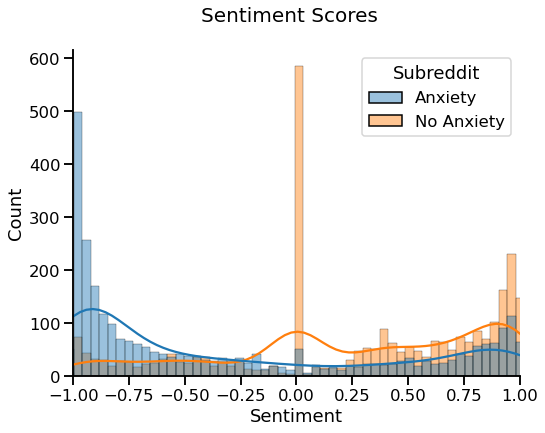

In [278]:
plt.figure(figsize=(8,6))
g = sns.histplot(df, x='Sentiment', hue='Subreddit', kde=True, legend=True, alpha=.45, bins=150);
sns.despine(top=True);
g.set_xlim(-1, 1)
plt.suptitle('Sentiment Scores', fontsize=20);
plt.savefig(f'{images_path}/sentiment_dist.png', bbox_inches='tight', dpi=300)

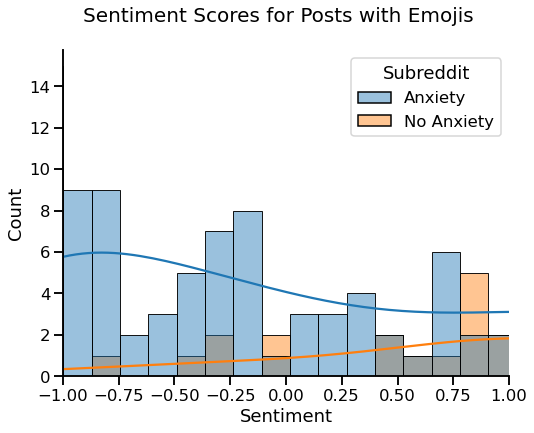

In [279]:
plt.figure(figsize=(8,6))
df_with_emojis = df[df['Emojis'].str.len()>0]
g = sns.histplot(df_with_emojis, x='Sentiment', hue='Subreddit', kde=True, legend=True, alpha=.45, bins=45);
sns.despine(top=True);
g.set_xlim(-1, 1)
plt.suptitle('Sentiment Scores for Posts with Emojis', fontsize=20);
plt.savefig(f'{images_path}/sentiment_dist_emoji.png', bbox_inches='tight', dpi=300)

In [280]:
df.fillna('', inplace=True)

#data = df.sample(n=1000, random_state=1)
data = df.copy()

X = data['Text']
y = data['Label']

In [281]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, 
                                                            stratify=y, 
                                                            random_state=42)

In [282]:
X.shape

(6000,)

In [283]:
import re
def get_short(text):
    """
    Extracts the short string for estimators and transformers to be used in pipes.
    """
    if text is None:
        return None
    # https://stackoverflow.com/questions/1175208/elegant-python-function-to-convert-camelcase-to-snake-case
    pattern = re.compile(r'(?<!^)(?=[A-Z])')
    text = pattern.sub('_', text).lower()
    return ''.join([t[0] for t in text.split('_')])

In [284]:
from emoji_sentiment_tools_simple import get_sentiment_score

class TextSentimentizer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_ = X.copy()
        SENT = X_.apply(lambda t: get_sentiment_score(t))
        d = pd.DataFrame(SENT)
        d.columns = ['SENT']
        return d
            
class NoSentimentizer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_ = X.copy()
        SENT = X_.apply(lambda t: 0)
        d = pd.DataFrame(SENT)
        d.columns = ['SENT']
        return d      


In [286]:
def save_model(mdl, models_path, mdl_name):
  """
  Saves model into a pickle
  """
  # models_path = '/content/drive/MyDrive/GA/models'
  # mdl_name = 'test'
  mdl_path = f'{models_path}/{mdl_name}.pkl'


  with open(mdl_path, 'wb') as pickle_out:
      pickle_out = pickle.dump(mdl, pickle_out)


from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer


transformer = 'CountVectorizer'
estimator = 'LogisticRegression'
sentimentizer = 'TextSentimentizer'


col_transformer = make_column_transformer(
     (CountVectorizer(), 'Text'),
     (TextSentimentizer(), 'Text'),
)


#print(col_transformer)


pipe = Pipeline([
    (get_short(transformer), col_transformer),
    (get_short(estimator), eval(estimator)())    
])


pipe.fit(pd.DataFrame(X_train), y_train)
print(pipe.score(pd.DataFrame(X_train), y_train))
print(pipe.score(pd.DataFrame(X_test), y_test))

mdl_name = f'mdl_{transformer}_{estimator}_{sentimentizer}'

save_model(pipe, models_path, mdl_name)

pipe.predict(pd.DataFrame(pd.DataFrame(['hello', 'good morning'], columns=['Text'])))

0.9976190476190476
0.9755555555555555


array([1, 1])

In [325]:
#Function for plotting confusion matrix
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
def plot_matrix(model, X_test, name=''):
    if 'Sent' in name:
        X_test = pd.DataFrame(X_test)
    
    preds = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
    fig, ax = plt.subplots(figsize=(7, 7))
    
    # View confusion matrix
    plot_confusion_matrix(model, X_test, y_test, cmap = 'copper', values_format='d', ax = ax, display_labels=['Anxiety', 'No Anxiety'])
    
    # Labels, title and ticks
    label_font = {'size':'15'}  # Adjust to fit
    ax.set_xlabel('Predicted labels', fontdict=label_font);
    ax.set_ylabel('Observed labels', fontdict=label_font);

    title_font = {'size':'21'}  # Adjust to fit
    ax.set_title(f'Confusion Matrix\n{name}', fontdict=title_font);

    ax.tick_params(axis='both', which='major', labelsize=12)
    n = name.replace(' ', '_')
    plt.savefig(f'{images_path}/Azin_confusion_matrix_{n}.png', bbox_inches='tight', dpi=300)

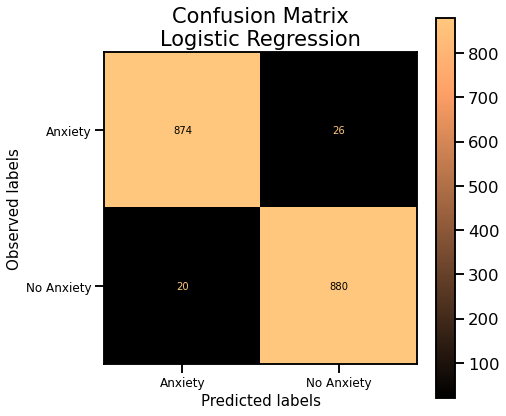

In [326]:
plot_matrix(lr_mdl, X_test, name='Logistic Regression')

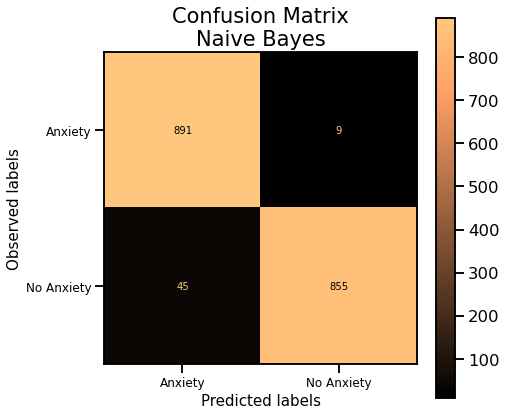

In [327]:
plot_matrix(mnb_mdl, X_test, name='Naive Bayes')

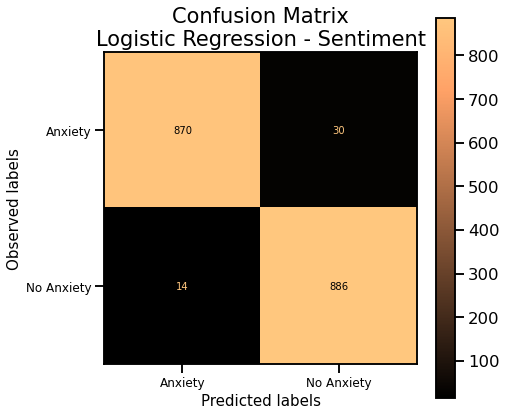

In [329]:
plot_matrix(lr_sent_mdl, X_test, name='Logistic Regression - Sentiment')